# Implementation of one-dimensional convolutional neural network

In [16]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

from keras.datasets import mnist

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
%matplotlib inline

# First, create appropriate test data

In [17]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 1, 784)
X_test = X_test.reshape(-1, 1, 784)

print(X_train.shape) ## (60000, 28, 28)
print(X_test.shape) ## (10000, 28, 28)
print(X_train[0].dtype) ## uint8
print(X_train[0])

(60000, 1, 784)
(10000, 1, 784)
uint8
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255
  247 127   0   0   0   0   0   0   0   0   0   0   0   0  30  36  94 154
  170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0   0   0
    0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82
   82  56  39   0   0   0   0   0   0   0   0   0   0   0   0  18 219 253


In [18]:
X_train = X_train.reshape(-1, 1, 784)
X_test = X_test.reshape(-1, 1, 784)

In [19]:
X_train = X_train[:2400]
y_train = y_train[:2400]
X_test = X_test[:600]
y_test = y_test[:600]

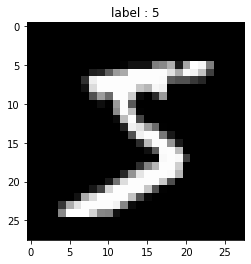

In [20]:
index = 0
image = X_train[index].reshape(28,28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

In [21]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

print(X_train.max()) ## 1.0
print(X_train.min()) ## 0.0

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

print(y_train.shape) ## (60000,)
print(y_train_one_hot.shape) ## (60000, 10)
print(y_train_one_hot.dtype) ## float64

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)

print(X_train.shape, y_train.shape) ## (48000, 784)
print(X_val.shape, y_val.shape) ## (12000, 784)

1.0
0.0
(2400,)
(2400, 10)
float64
(1920, 1, 784) (1920, 10)
(480, 1, 784) (480, 10)


# Problem 1
## Creation of a one-dimensional convolution layer class limited to one channel number

In [28]:
class Scratch1dCNNClassifier:
    """
    Number of nodes Fully connected layer from n_nodes1 to n_nodes2
     Parameters
     ----------
     n_nodes1: int
       Number of nodes in the previous layer
     n_nodes2: int
       Number of nodes in the later layer
     initializer: instance of initialization method
     optimizer: instance of optimization method
    """
    def __init__(self):       
        self.W = np.array([3,5,7]) 
        self.B = np.array([1])
        self.padding = 0
        self.strides = 1        
        self.filters = len(self.W)
        self.a = np.array([])
        self.dW = np.array([])
        
    def forward(self, X):
        """
        forward
         Parameters
         ----------
         X: ndarray, shape (batch_size, n_nodes_bf) of the following form
             input
         Returns
         ----------
         A: The following forms of ndarray, shape (batch_size, n_nodes_af)
             output
        """
        self.X = X
        self.N_in = len(self.X)
        self.N_out = int((self.N_in + 2*self.padding - self.filters) / self.strides + 1) ## Output size calculation
        
        self.a = np.append(self.a, [np.dot(self.X[i : i+self.filters], self.W) + self.B for i in range(self.N_out)])

        return self.a
    
    def backward(self, dA):
        """
        Backward
         Parameters
         ----------
         dA: ndarray, shape (batch_size, n_nodes2) of the following form
             Gradient flowing from behind
         Returns
         ----------
         dZ: ndarray, shape (batch_size, n_nodes1) of the following form
             Gradient to flow forward
        """
        self.dB = np.sum(dA, axis=0)        
        self.dW = np.append(self.dW, [np.dot(self.X[i : i+self.N_out].T, dA) for i in range(self.filters)])


        self.dX = np.zeros(len(self.X))            
        for j in range(len(self.X)):
            for s in range(len(self.W)):
                if j - s < 0 or j - s > 1:
                    self.dX[j] = self.dX[j]
                else:
                    self.dX[j] = self.dX[j] + dA[j - s] * self.W[s]

        return self.dX

# Problem 2 
## Calculation of output size after one-dimensional convolution

In [29]:
def calc_out_shape(N_in, P, F, S):
    N_out = ((N_in + 2 * P - F) / S) + 1
    return int(N_out)

In [30]:
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])
padding=0
stride = 1

calc_out_shape(4, padding, len(w), stride)

2

# Problem 3
## Experiment of one-dimensional convolution layer with small array

In [31]:
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])

In [32]:
model = Scratch1dCNNClassifier()
model.forward(x)

array([35., 50.])

In [33]:
delta_a = np.array([10, 20])
model.backward(delta_a)

array([ 30., 110., 170., 140.])

# Problem 4
## Creation of a one-dimensional convolution layer class that does not limit the number of channels

In [37]:
class Conv1d:
    """
    Number of nodes Fully connected layer from n_nodes1 to n_nodes2
     Parameters
     ----------
     n_nodes1: int
       Number of nodes in the previous layer
     n_nodes2: int
       Number of nodes in the later layer
     initializer: instance of initialization method
     optimizer: instance of optimization method
    """
    def __init__(self):       
        self.W = np.ones((3, 2, 3)) 
        self.B = np.array([1, 2, 3])
        self.padding = 0
        self.strides = 1        
        self.filters = self.W.shape[2]        
        #self.a = np.array([])
        #self.dW = np.array([])
        
    def forward(self, X):
        """
        forward
         Parameters
         ----------
         X: ndarray, shape (batch_size, n_nodes_bf) of the following form
             input
         Returns
         ----------
         A: The following forms of ndarray, shape (batch_size, n_nodes_af)
             output
        """
        self.X = X
        self.N_in = self.X.shape[1]
        self.N_out = int((self.N_in + 2*self.padding - self.filters) / self.strides + 1) ## Output size calculation

        self.a = np.zeros((self.W.shape[0], self.N_out)) ## Number of output channels, output size
        for i in range(self.W.shape[0]): ## Output channel
            for j in range(self.X.shape[0]): ## Input channel
                for s in range(self.N_out): ## Output size
                    self.a[i, j] = self.a[i, j] + np.dot(self.X[j, s: s+self.filters], self.W[i, j])
                    
        ## bias
        self.a = self.a + self.B.reshape(-1, 1)

        return self.a
    
    def backward(self, dA):
        """
        Backward
         Parameters
         ----------
         dA: ndarray, shape (batch_size, n_nodes2) of the following form
             Gradient flowing from behind
         Returns
         ----------
         dZ: ndarray, shape (batch_size, n_nodes1) of the following form
             Gradient to flow forward
        """
        self.dB = np.sum(dA, axis=1)
        
        self.dW = np.zeros((self.W.shape[0], self.X.shape[0], self.filters)) ## Number of output channels, output size, filter size
        for i in range(self.W.shape[0]): ## Output channel
            for j in range(self.X.shape[0]): ## Input channel
                for s in range(self.filters): ## Filter size
                        self.dW[i, j, s] = np.dot(self.X[j][s : s+self.N_out].T, dA[s])

        self.dX = np.zeros(self.X.shape)
        for i in range(self.W.shape[0]): ## Output channel
            for j in range(self.X.shape[0]): ## Input channel
                for s in range(self.filters): ## Filter size
                    for n in range(self.N_out): ## Output size
                        self.dX[j, s + n] = self.dX[j, s + n] + dA[i, n] * self.W[i, j, s]

        return self.dX

Let's check the output as in problem 3.

In forward propagation, when the inputs and parameters are as follows

In [38]:
model = Conv1d()
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]) ## shape (2, 4), (number of input channels, number of features).
w = np.ones((3, 2, 3)) ## All are set to 1 for simplification of the example. (Number of output channels, number of input channels, filter size).
b = np.array([1, 2, 3]) ## （Number of output channels)

In [39]:
model.forward(x)

array([[16., 22.],
       [17., 23.],
       [18., 24.]])

In [40]:
delta_a = np.array([[10, 20], [10, 20], [10, 20]])
model.backward(delta_a)

array([[30., 90., 90., 60.],
       [30., 90., 90., 60.]])

# Problem 8 
## Learning and estimation

In [42]:
class Flatten():
    def __init__(self):
        self.X_shape = None
    
    def forward(self, X):
        ## 1D
        X_1d = X.reshape(X.shape[0], -1)
        
        ## shape record
        self.X_shape = X.shape
        
        return X_1d    

    def backward(self, X):
        ## Return of shape
        X = X.reshape(self.X_shape)
        
        return X

In [47]:
class Scratch1dCNNClassifier:
    """
    Deep neural network classifier

    Parameters
    --------------
    activaiton: {'sigmoid','tanh','relu'}
        Types of activation functions
    n_nodes: list
        Node configuration example [400, 200, 100]
    n_output: int
        Number of output layers
    alpha: float
        Learning rate
    optimizer: {'sgd','adagrad'}
        Types of optimization methods
    filter_num: int
        Number of filters
    filter_size: int
        Filter size
        
    Attributes
    -------------
    FC [n_layers]: dict
        A dictionary that manages the connection layer
    activation: dict
        A dictionary that manages the activation function
    self.epochs: int
        Number of epochs (initial value: 10)
    self.batch_size: int
        Batch size (initial value: 20)
    self.n_features: int
        Number of features
    self.val_is_true: boolean
        Presence or absence of verification data
    self.loss: empty ndarray
        Record losses on training data
    self.loss_val: empty ndarray
        Record loss on validation data
        
    """    
    def __init__(self, activation, n_nodes, n_output, lr, optimizer, filter_num, filter_size):
        self.select_activation = activation
        self.n_nodes = n_nodes
        self.n_output = n_output
        self.lr = lr
        self.select_optimizer = optimizer
        
        # Sprint11 addition*******************************
        self.filter_num  = filter_num                         #Number of filters
        self.filter_size   = filter_size   #Filter size
        # Sprint11 added *********************************
            
    def __initialize_n_layers(self):
        """
       Initialize the N layer.
         When the sigmoid function and tanh function are activation functions: Xavier is the initial value
         If the ReLU function is an activation function: He is the initial value
        """
        self.activation = dict()
        self.FC = dict()
        # Sprint11 addition************************************************* 
        #n_nodes = self.out // (2**(1))
        if self.select_activation == 'sigmoid':
            self.FC[0] = FC(self.out, self.n_nodes[0], 
                            XavierInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
            self.activation[0] = Sigmoid()
        elif self.select_activation == 'tanh':
            self.FC[0] = FC(self.out, self.n_nodes[0], 
                            XavierInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
            self.activation[0] = Tanh()
        elif self.select_activation == 'relu':
            self.FC[0] = FC(self.out, self.n_nodes[0], 
                            HeInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
            self.activation[0] = ReLU()
        # Sprint11 addition************************************************* 

        for n_layer in range(len(self.n_nodes)):            
            if n_layer == len(self.n_nodes) -1:
                if self.select_activation == 'sigmoid':
                    self.FC[n_layer + 1] = FC(self.n_nodes[n_layer], self.n_output, 
                                              XavierInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
                    self.activation[n_layer + 1] = Softmax()
                elif self.select_activation == 'tanh':
                    self.FC[n_layer + 1] = FC(self.n_nodes[n_layer], self.n_output,
                                              XavierInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
                    self.activation[n_layer + 1] = Softmax()
                elif self.select_activation == 'relu':
                    self.FC[n_layer + 1] = FC(self.n_nodes[n_layer], self.n_output,
                                              HeInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
                    self.activation[n_layer + 1] = Softmax()
            else:
                if self.select_activation == 'sigmoid':
                    self.FC[n_layer + 1] = FC(self.n_nodes[n_layer], self.n_nodes[n_layer+1], 
                                              XavierInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
                    self.activation[n_layer + 1] = Sigmoid()
                elif self.select_activation == 'tanh':
                    self.FC[n_layer + 1] = FC(self.n_nodes[n_layer], self.n_nodes[n_layer+1],
                                              XavierInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
                    self.activation[n_layer + 1] = Tanh()
                elif self.select_activation == 'relu':
                    self.FC[n_layer + 1] = FC(self.n_nodes[n_layer], self.n_nodes[n_layer+1],
                                              HeInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
                    self.activation[n_layer + 1] = ReLU()
    
    def fit(self, X, y, epochs=10, batch_size=20):  
        self.epochs = epochs                            #Epoch number    
        self.batch_size = batch_size              #Batch size
        self.loss = np.zeros(self.epochs)        # For output of learning curve / objective function (training data)
        self.loss_val = np.zeros(self.epochs) # For output of learning curve / objective function (verification data)        
        
        if self.select_optimizer == 'sgd':
            self.optimizer = SGD(self.lr)
        elif self.select_optimizer == 'adagrad':
            self.optimizer = AdaGrad(self.lr)            
        
        # Sprint11 added ************************************************* 
         # Convolution layer class
        self.input_channel = X.shape[1]
        self.input_feature = X.shape[2]
        
        self.conv1d = Conv1d(self.select_activation, self.optimizer, self.filter_num, self.input_channel, self.filter_size)
        if self.select_activation == 'sigmoid':
            self.activation_conv = Sigmoid()
        elif self.select_activation == 'tanh':
            self.activation_conv = Tanh()
        elif self.select_activation == 'relu':
            self.activation_conv = ReLU()
 
        #Get mini-batch
        get_mini_batch = GetMiniBatch(X, y, self.batch_size)

        # Smoothing class
        self.flatten = Flatten()
        self.out = self.filter_num * (self.input_feature - (self.filter_size - 1))
        # Sprint11 addition*************************************************         
        
        self.__initialize_n_layers()
        
        for epoch in range(self.epochs):
            #get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size) # Sprint11 Delete
            print("epoch ", epoch + 1 , " processing . . .")
            for mini_X_train,  mini_y_train in get_mini_batch:
                self.X_ = mini_X_train
                self.y_ = mini_y_train
                
                # Forward propagation
                 # Sprint11 added ************************************************* 
                 # Convolution (1st layer)
                self.A = self.conv1d.forward(self.X_) 
                self.Z = self.activation_conv.forward(self.A)    
                
                #Smoothing
                self.F = self.flatten.forward(self.Z)
                               
                self.A = self.FC[0].forward(self.F)
                self.Z = self.activation[0].forward(self.A)                         
                
                # Sprint11 addition************************************************* 
                
                self.A = self.FC[1].forward(self.Z)            #1st layer
                self.Z = self.activation[1].forward(self.A) #1st layer
                for n_layer in range(2, len(self.n_nodes) + 1): #2nd and subsequent layers
                    self.A = self.FC[n_layer].forward(self.Z)
                    self.Z = self.activation[n_layer].forward(self.A)
                
                # Backpropagation
                self.dA, self.loss[epoch] = self.activation[len(self.n_nodes)].backward(self.Z, self.y_) #Final layer, cross entropy error                self.dZ = self.FC[len(self.n_nodes)].backward(self.dA) #最終層           
                for n_layer in reversed(range(0, len(self.n_nodes))): #Final layer -1
                    self.dA = self.activation[n_layer].backward(self.dZ)
                    self.dZ = self.FC[n_layer].backward(self.dA)

                # Sprint11 addition********************************
                 # Shape back
                self.dF = self.flatten.backward(self.dZ)
                
                # Convolution layer
                self.dA = self.activation_conv.backward(self.dF)
                self.dZ = self.conv1d.backward(self.dA)
                # Sprint11 addition********************************
                
    def predict(self,X):
        
        # Sprint11 addition********************************
         # Convolution (1st layer)
        self.A = self.conv1d.forward(X) 
        self.Z = self.activation_conv.forward(self.A)    

        #Smoothing
        self.F = self.flatten.forward(self.Z)

        self.A = self.FC[0].forward(self.F)            # 1 layer
        self.Z = self.activation[0].forward(self.A) # 1 layer
         # Sprint11 added ********************************
        
        # Forward propagation
        self.A = self.FC[1].forward(self.Z)                    # 1 layer
        self.Z = self.activation[1].forward(self.A) # 1 layer
        for n_layer in range(2, len(self.n_nodes) + 1): # 2nd layer and beyond
            self.A = self.FC[n_layer].forward(self.Z)
            self.Z = self.activation[n_layer].forward(self.A)
        
        return np.argmax(self.Z, axis=1)

In [48]:
class Conv1d:
    """
    Number of nodes Fully connected layer from n_nodes1 to n_nodes2
     Parameters
    ----------
    n_nodes1 : int
      Number of nodes in the previous layer
    n_nodes2 : int
      Number of nodes in the later layer
    initializer : Instance of initialization method
    optimizer : Instance of optimization method
    """
    def __init__(self, activation, optimizer, filter_num, input_channel, filter_size):
        self.activation = activation
        self.optimizer = optimizer
        self.filter_num = filter_num
        self.input_channel = input_channel
        self.filter_size = filter_size
        self.pad = 0
        self.stride = 1
        
        if self.activation == 'sigmoid':
            initializer = XavierInitializer(self.filter_num, self.input_channel, self.filter_size)
            self.W = initializer.W(_, _)
            self.B = initializer.B(_)            
        elif self.activation == 'tanh':
            initializer = XavierInitializer(self.filter_num, self.input_channel, self.filter_size)
            self.W = initializer.W(_, _)
            self.B = initializer.B(_)          
        elif self.activation == 'relu':
            initializer = HeInitializer(self.filter_num, self.input_channel, self.filter_size)
            self.W = initializer.W(_, _)
            self.B = initializer.B(_)

        self.X = None
        self.N_in = None
        self.N_out = None
        self.a = None
        self.dB = None
        self.dW = None
        self.dX = None
        
    def forward(self, X):
        """
        forward
        Parameters
        ----------
        X : The following form ndarray, shape (batch_size, n_nodes_bf)
            input
        Returns
        ----------
        A : The following form ndarray, shape (batch_size, n_nodes_af)
            output
        """
        self.X = X
        
        ## Get shape
        batch_size, input_channel, self.N_in = self.X.shape 
        FN, C, FS = self.W.shape 
        
        self.N_out = int((self.N_in + 2*self.pad - self.filter_size) / self.stride + 1) 

        self.a = np.zeros((batch_size, FN, self.N_out)) 
        for b in range(batch_size): 
            for i in range(FN): 
                for j in range(C): 
                    for s in range(self.N_out): 
                        self.a[b, i, s] = self.a[b, i, s] + np.sum(self.X[b, j, s: s+self.filter_size] * self.W[i, j, :])
                        
       ## bias
        self.a = self.a + self.B.reshape(1, -1, 1)

        return self.a
       
    def backward(self, dA):
        """
        Backward
        Parameters
        ----------
        dA : The following form ndarray, shape (batch_size, n_nodes2)
            Gradient flowing from behind
        Returns
        ----------
        dZ : The following form ndarray, shape (batch_size, n_nodes1)
            Gradient to flow forward
        """
        batch, C, W = self.X.shape 
        FN, C, FS = self.W.shape 
        
        ## Empty array
        self.dW = np.zeros(self.W.shape) 
        self.dX = np.zeros(self.X.shape) 

        self.dB = np.sum(dA, axis=2)
        
        for b in range(batch): 
            for i in range(FN): 
                for j in range(C):
                    for s in range(FS): 
                        for x in range(self.N_out): 
                            self.dW[i, j, s] = self.dW[i, j, s] + dA[b, i, x] * self.X[b, j, s + x]
                            self.dX[b, j, s + x] = self.dX[b, j, s + x] + dA[b, i, x] * self.W[i, j, s]

        ## Update
        self = self.optimizer.update(self)
        
        return self.dX


In [49]:
class FC:
    """
     Number of nodes Fully connected layer from n_nodes1 to n_nodes2
    Parameters
    ----------
    n_nodes1 : int
     Number of nodes in the previous layer
    n_nodes2 : int
      Number of nodes in the later layer
    initializer : Instance of initialization method
    optimizer : Instance of optimization method
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.optimizer = optimizer
        
        ## Initialize
        
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
    
    def forward(self, X):
        """
        forward
         Parameters
         ----------
         X: ndarray, shape (batch_size, n_nodes1) of the following form
             input
         Returns
         ----------
         A: ndarray, shape (batch_size, n_nodes2) of the following form
             output
        """        
        self.X = X
        
        return np.dot(self.X, self.W) + self.B
    
    def backward(self, dA):
        """
        Backward
         Parameters
         ----------
         dA: ndarray, shape (batch_size, n_nodes2) of the following form
             Gradient flowing from behind
         Returns
         ----------
         dZ: ndarray, shape (batch_size, n_nodes1) of the following form
             Gradient to flow forward
        """
        self.dB = dA
        self.dW = np.dot(self.X.T, dA)
        dZ = np.dot(dA, self.W.T)

        ## Update
        self = self.optimizer.update(self)
        
        return dZ

In [50]:
class XavierInitializer:
    """
    Xavier class
    """
    
    def __init__(self, filter_num=None, input_channel=None, filter_size=None):        
        self.filter_num = filter_num
        self.input_channel = input_channel
        self.filter_size = filter_size
     
        
    def W(self, n_nodes1, n_nodes2):
        """
        Weight initialization
         Parameters
         ----------
         n_nodes1: int
           Number of nodes in the previous layer
         n_nodes2: int
           Number of nodes in the later layer

         Returns
         ----------
         W: ndarray, shape (n_nodes1, n_nodes2) of the following form
             weight
        """
                
        if self.filter_num and self.input_channel and self.filter_size is not None: 
            W = np.random.randn(self.filter_num, self.input_channel, self.filter_size)
        else: 
        
            W = np.random.randn(n_nodes1, n_nodes2) / np.sqrt(n_nodes1)       
        
        return W
        
    def B(self, n_nodes2):
        """
        Bias initialization
         Parameters
         ----------
         n_nodes2: int
           Number of nodes in the later layer

         Returns
         ----------
         B: ndarray, shape (n_nodes2,) of the following form
             bias
        """
                
        if self.filter_num and self.input_channel and self.filter_size is not None: 
            B = np.random.randn(self.filter_num)
        else: 
        
            B = np.zeros(n_nodes2)
        
        return B

In [51]:
class HeInitializer:
    """
    He class
    """
    
    def __init__(self, filter_num=None, input_channel=None, filter_size=None):        
        self.filter_num = filter_num
        self.input_channel = input_channel
        self.filter_size = filter_size
           
        
    def W(self, n_nodes1, n_nodes2):
        """
       Weight initialization
         Parameters
         ----------
         n_nodes1: int
           Number of nodes in the previous layer
         n_nodes2: int
           Number of nodes in the later layer

         Returns
         ----------
         W: ndarray, shape (n_nodes1, n_nodes2) of the following form
             weight
        """
               
        if self.filter_num and self.input_channel and self.filter_size is not None: 
            W = np.random.randn(self.filter_num, self.input_channel, self.filter_size) * np.sqrt(2 / self.filter_num) 
        else: 
        
            W = np.random.randn(n_nodes1, n_nodes2) * np.sqrt(2 / n_nodes1)
    
        return W
        
    def B(self, n_nodes2):
        """
        Bias initialization
         Parameters
         ----------
         n_nodes2: int
           Number of nodes in the later layer

         Returns
         ----------
         B: ndarray, shape (n_nodes2,) of the following form
             bias
        """
              
        if self.filter_num and self.input_channel and self.filter_size is not None: 
            B = np.random.randn(self.filter_num)
        else: 
        
            B = np.random.randn(n_nodes2)
        
        return B

In [52]:
class SGD:
    """
Stochastic gradient descent
     Parameters
     ----------
     lr: Learning rate
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
       Update weights and biases for a layer
         Parameters
         ----------
         layer: Instance of the layer before update
        
         Returns
         ----------
         layer: Updated layer instance
        """
        layer.W = layer.W - self.lr * layer.dW
        layer.B = layer.B - self.lr * layer.dB.mean(axis=0)
        
        return layer

In [53]:
class AdaGrad:
    """
    AdaGrad class
     Parameters
     ----------
     alpha: Learning rate
    
     Attributes
     -------------
     lr: Learning rate
     HW: int (initial value), ndarray
     HB: int (initial value), ndarray
    """    
    def __init__(self, lr):
        self.lr = lr
        self.HW= 0 
        self.HB = 0       

    def update(self, layer):
        """
        Update weights and biases for a layer
         Parameters
         ----------
         layer: instance
             Instance of the layer before update

         Returns
         ----------
         layer: instance
             Updated tier instance
        """
        ## Initialize
        self.HW = np.zeros_like(layer.W)
        self.HB = np.zeros_like(layer.B)
        
       ## update
        self.HW = self.HW + (layer.dW**2) #/ layer.dB.shape[0]
        self.HB = self.HB + (layer.dB**2).mean(axis=0)
        layer.W = layer.W - self.lr * 1 / np.sqrt(self.HW + 1e-7) * layer.dW #/ layer.dB.shape[0]
        layer.B = layer.B - self.lr * 1 / np.sqrt(self.HB + 1e-7) * layer.dB.mean(axis=0)
        
        return layer

In [54]:
class Sigmoid:
    def __init__(self):
        pass
    
    def forward(self, A):
        self.A = A
        
        self.Z = 1.0 / (1.0 + np.exp(-self.A))
        
        return self.Z
    
    def backward(self, dZ):

        return dZ * (1 - self.Z) * self.Z

In [55]:
class Tanh:
    def __init__(self):
        pass
    
    def forward(self, A):
        self.A = A
        
        return np.tanh(self.A)
    
    def backward(self, dZ):
        
        return dZ * (1.0 - (np.tanh(self.A) ** 2))

In [56]:
class ReLU:
    def __init__(self):
        pass
        
    def forward(self, A):    
        self.A = A
        return np.maximum(self.A, 0)
    
    def backward(self, dZ):
        return np.where(self.A > 0, dZ, 0)

In [57]:
class Softmax:
    def __init__(self):
        pass
    
    def forward(self, A):
        
        return np.exp(A) / np.sum(np.exp(A), axis=1, keepdims=True)
    
    def backward(self, Z, y):
        
        dA = Z - y
        
        ## Cross entropy error
        batch_size = y.shape[0]
        loss = -np.sum(y * np.log(Z)) / batch_size

        return dA, loss

In [ ]:
model = Scratch1dCNNClassifier(activation='tanh', n_nodes=[400, 200, 100], n_output=10, lr=0.001, optimizer='sgd', filter_num=3, filter_size=3)
model.fit(X_train, y_train, epochs=15, batch_size=10)
y_pred = model.predict(X_test)

In [ ]:
print("accuracy : {}".format(accuracy_score(y_test, y_pred)))
print("\n")
print(classification_report(y_test, y_pred))